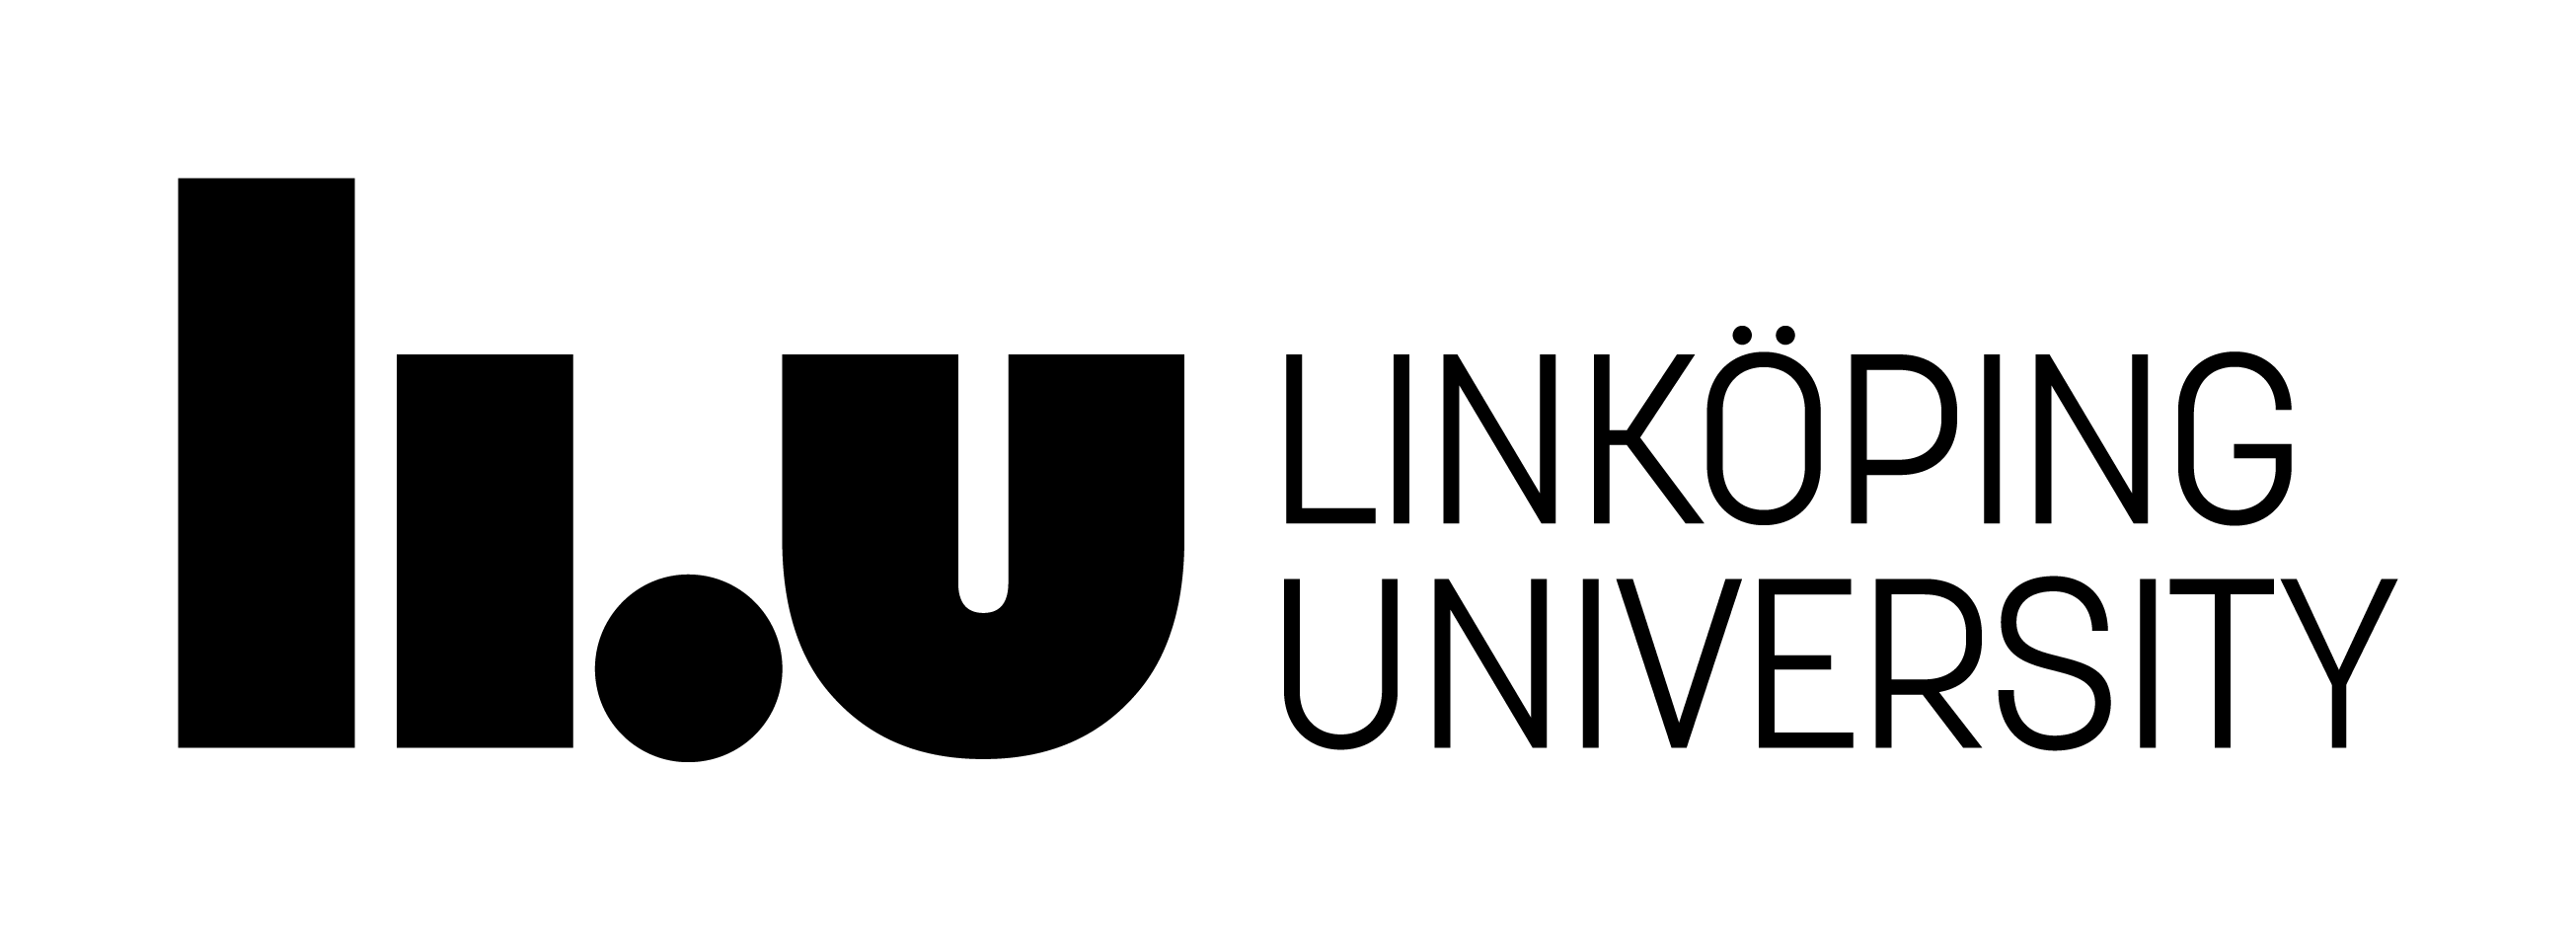
## Linkoping University: TDDC17 Artificial Intelligence
---



**Lab5 : Deep Learning**

**Lab5.3 :RNN-LSTM Implementation**

  In this assignment, you will learn how to implement a RNN and LSTM for sequential data. We will use the deep learning library PyTorch, which is well-known for its ease of use

The goal is to classify sequences.
Elements and targets are represented locally (input vectors with only one non-zero bit).
The sequence starts with an B, ends with a E (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set {a, b, c, d} except for two elements at positions t1 and t2 that are either X or Y.
For the DifficultyLevel.HARD case, the sequence length is randomly chosen between 100 and 110, t1 is randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60.
There are 4 sequence classes Q, R, S, and U, which depend on the temporal order of X and Y.

The rules are:

- X, X -> Q,
- X, Y -> R,
- Y, X -> S,
- Y, Y -> U.


# Instaling and Loading packages

In [ ]:
# Install compatible versions
!pip install torch==2.1.0+cu117 torchvision==0.16.0+cu117 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install numpy==1.26.4


# Dataset Exploration

In [4]:
import numpy as np
import six

def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    lengths = []
    for x in sequences:
        if not hasattr(x, '__len__'):
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))
        lengths.append(len(x))

    num_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.str_)
    if isinstance(value, six.string_types) and dtype != object and not is_dtype_str:
        raise ValueError("`dtype` {} is not compatible with `value`'s type: {}\n"
                         "You should set `dtype=object` for variable length strings."
                         .format(dtype, type(value)))

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" '
                             'not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s '
                             'is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

class EchoData():

    def __init__(self, series_length=40000, batch_size=32,
                 echo_step=3, truncated_length=10, seed=None):

        self.series_length = series_length
        self.truncated_length = truncated_length
        self.n_batches = series_length//truncated_length

        self.echo_step = echo_step
        self.batch_size = batch_size
        if seed is not None:
            np.random.seed(seed)
        self.x_batch = None
        self.y_batch = None
        self.x_chunks = []
        self.y_chunks = []
        self.generate_new_series()
        self.prepare_batches()

    def __getitem__(self, index):
        if index == 0:
            self.generate_new_series()
            self.prepare_batches()
        return self.x_chunks[index], self.y_chunks[index]

    def __len__(self):
        return self.n_batches

    def generate_new_series(self):
        x = np.random.choice(
            2,
            size=(self.batch_size, self.series_length),
            p=[0.5, 0.5])
        y = np.roll(x, self.echo_step, axis=1)
        y[:, 0:self.echo_step] = 0
        self.x_batch = x
        self.y_batch = y

    def prepare_batches(self):
        x = np.expand_dims(self.x_batch, axis=-1)
        y = np.expand_dims(self.y_batch, axis=-1)
        self.x_chunks = np.split(x, self.n_batches, axis=1)
        self.y_chunks = np.split(y, self.n_batches, axis=1)

class TemporalOrderExp6aSequence():
    """
    From Hochreiter&Schmidhuber(1997):

        The goal is to classify sequences. Elements and targets are represented locally
        (input vectors with only one non-zero bit). The sequence starts with an E, ends
        with a B (the "trigger symbol") and otherwise consists of randomly chosen symbols
        from the set {a, b, c, d} except for two elements at positions t1 and t2 that are
        either X or Y . The sequence length is randomly chosen between 100 and 110, t1 is
        randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60.
        There are 4 sequence classes Q, R, S, U which depend on the temporal order of X and Y.
        The rules are:
            X, X -> Q,
            X, Y -> R,
            Y , X -> S,
            Y , Y -> U.

    """

    def __init__(self, length_range=(100, 111), t1_range=(10, 21), t2_range=(50, 61),
                 batch_size=32, seed=None):

        self.classes = ['Q', 'R', 'S', 'U']
        self.n_classes = len(self.classes)

        self.relevant_symbols = ['X', 'Y']
        self.distraction_symbols = ['a', 'b', 'c', 'd']
        self.start_symbol = 'B'
        self.end_symbol = 'E'

        self.length_range = length_range
        self.t1_range = t1_range
        self.t2_range = t2_range
        self.batch_size = batch_size

        if seed is not None:
            np.random.seed(seed)

        all_symbols = self.relevant_symbols + self.distraction_symbols + \
                      [self.start_symbol] + [self.end_symbol]
        self.n_symbols = len(all_symbols)
        self.s_to_idx = {s: n for n, s in enumerate(all_symbols)}
        self.idx_to_s = {n: s for n, s in enumerate(all_symbols)}

        self.c_to_idx = {c: n for n, c in enumerate(self.classes)}
        self.idx_to_c = {n: c for n, c in enumerate(self.classes)}

    def generate_pair(self):
        length = np.random.randint(self.length_range[0], self.length_range[1])
        t1 = np.random.randint(self.t1_range[0], self.t1_range[1])
        t2 = np.random.randint(self.t2_range[0], self.t2_range[1])

        x = np.random.choice(self.distraction_symbols, length)
        x[0] = self.start_symbol
        x[-1] = self.end_symbol

        y = np.random.choice(self.classes)
        if y == 'Q':
            x[t1], x[t2] = self.relevant_symbols[0], self.relevant_symbols[0]
        elif y == 'R':
            x[t1], x[t2] = self.relevant_symbols[0], self.relevant_symbols[1]
        elif y == 'S':
            x[t1], x[t2] = self.relevant_symbols[1], self.relevant_symbols[0]
        else:
            x[t1], x[t2] = self.relevant_symbols[1], self.relevant_symbols[1]

        return ''.join(x), y

    # encoding/decoding single instance version

    def encode_x(self, x):
        idx_x = [self.s_to_idx[s] for s in x]
        return to_categorical(idx_x, num_classes=self.n_symbols)

    def encode_y(self, y):
        idx_y = self.c_to_idx[y]
        return to_categorical(idx_y, num_classes=self.n_classes)

    def decode_x(self, x):
        x = x[np.sum(x, axis=1) > 0]    # remove padding
        return ''.join([self.idx_to_s[pos] for pos in np.argmax(x, axis=1)])

    def decode_y(self, y):
        return self.idx_to_c[np.argmax(y)]

    # encoding/decoding batch versions

    def encode_x_batch(self, x_batch):
        return pad_sequences([self.encode_x(x) for x in x_batch],
                             maxlen=self.length_range[1])

    def encode_y_batch(self, y_batch):
        return np.array([self.encode_y(y) for y in y_batch])

    def decode_x_batch(self, x_batch):
        return [self.decode_x(x) for x in x_batch]

    def decode_y_batch(self, y_batch):
        return [self.idx_to_c[pos] for pos in np.argmax(y_batch, axis=1)]

    def __len__(self):
        """ Let's assume 1000 sequences as the size of data. """
        return int(1000. / self.batch_size)

    def __getitem__(self, index):
        batch_x, batch_y = [], []
        for _ in range(self.batch_size):
            x, y = self.generate_pair()
            batch_x.append(x)
            batch_y.append(y)
        return self.encode_x_batch(batch_x), self.encode_y_batch(batch_y)

    class DifficultyLevel:
        """ On HARD, settings are identical to the original settings from the '97 paper."""
        EASY, NORMAL, MODERATE, HARD, NIGHTMARE = range(5)

    @staticmethod
    def get_predefined_generator(difficulty_level, batch_size=32, seed=8382):
        EASY = TemporalOrderExp6aSequence.DifficultyLevel.EASY
        NORMAL = TemporalOrderExp6aSequence.DifficultyLevel.NORMAL
        MODERATE = TemporalOrderExp6aSequence.DifficultyLevel.MODERATE
        HARD = TemporalOrderExp6aSequence.DifficultyLevel.HARD

        if difficulty_level == EASY:
            length_range = (7, 9)
            t1_range = (1, 3)
            t2_range = (4, 6)
        elif difficulty_level == NORMAL:
            length_range = (30, 41)
            t1_range = (2, 6)
            t2_range = (20, 28)
        elif difficulty_level == MODERATE:
            length_range = (60, 81)
            t1_range = (10, 21)
            t2_range = (45, 55)
        elif difficulty_level == HARD:
            length_range = (100, 111)
            t1_range = (10, 21)
            t2_range = (50, 61)
        else:
            length_range = (300, 501)
            t1_range = (10, 81)
            t2_range = (250, 291)
        return TemporalOrderExp6aSequence(length_range, t1_range, t2_range,
                                          batch_size, seed)


In [5]:
# Create a data generator.
datagenerator = TemporalOrderExp6aSequence()
example_generator = datagenerator.get_predefined_generator(
    # The first argument is the difficulty level of the classification task.
    difficulty_level=datagenerator.DifficultyLevel.EASY,
    # The second argument is the number of sequences generated in each batch of data.
    batch_size=32,
)

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [7]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


# Defining the RNN-LSTM Models

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        # Todo : implement RNN using pytorch nn module torch.nn.RNN(input_size, hidden_size, nonlinearity, batch_first)
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, nonlinearity="tanh", batch_first=False)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # Todo : implement LSTM using pytorch nn module torch.nn.LSTM(input_size, hidden_size, batch_first)
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x

    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

# Defining the Training Loop

In [9]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)

        loss = criterion(output, target)

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

# Defining the Testing Loop


In [10]:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

# Putting it All Together

In [11]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

# Simple RNN: 10 Epochs


[Epoch 1/10] loss: 1.4229, acc: 23.79% - test_loss: 1.3671, test_acc: 26.61%
[Epoch 2/10] loss: 1.3751, acc: 24.29% - test_loss: 1.3853, test_acc: 26.51%
[Epoch 3/10] loss: 1.3838, acc: 24.50% - test_loss: 1.3943, test_acc: 23.99%
[Epoch 4/10] loss: 1.3919, acc: 24.60% - test_loss: 1.3858, test_acc: 24.90%
[Epoch 5/10] loss: 1.3838, acc: 25.81% - test_loss: 1.3934, test_acc: 23.89%
[Epoch 6/10] loss: 1.3845, acc: 25.81% - test_loss: 1.3830, test_acc: 22.68%
[Epoch 7/10] loss: 1.3835, acc: 25.71% - test_loss: 1.3946, test_acc: 23.08%
[Epoch 8/10] loss: 1.3839, acc: 27.62% - test_loss: 1.3920, test_acc: 25.71%
[Epoch 9/10] loss: 1.3975, acc: 24.50% - test_loss: 1.3866, test_acc: 24.09%
[Epoch 10/10] loss: 1.3936, acc: 25.30% - test_loss: 1.3851, test_acc: 25.40%


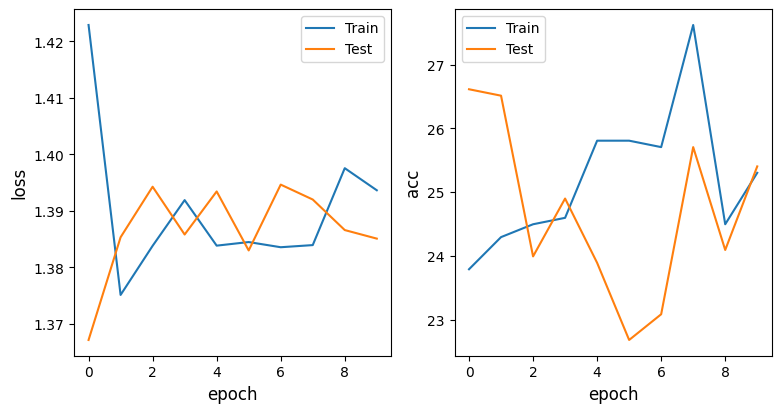

In [12]:
# Setup the training and test data generators
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

#Simple LSTM: 10 Epochs


[Epoch 1/10] loss: 1.3327, acc: 25.40% - test_loss: 1.4529, test_acc: 23.19%
[Epoch 2/10] loss: 1.4129, acc: 24.29% - test_loss: 1.4149, test_acc: 23.69%
[Epoch 3/10] loss: 1.3908, acc: 25.00% - test_loss: 1.4066, test_acc: 26.61%
[Epoch 4/10] loss: 1.3722, acc: 22.88% - test_loss: 1.3817, test_acc: 24.90%
[Epoch 5/10] loss: 1.4206, acc: 25.81% - test_loss: 1.3846, test_acc: 24.09%
[Epoch 6/10] loss: 1.3849, acc: 23.79% - test_loss: 1.3990, test_acc: 28.02%
[Epoch 7/10] loss: 1.3889, acc: 21.77% - test_loss: 1.3774, test_acc: 25.40%
[Epoch 8/10] loss: 1.3884, acc: 20.97% - test_loss: 1.3830, test_acc: 24.40%
[Epoch 9/10] loss: 1.3871, acc: 25.20% - test_loss: 1.3905, test_acc: 23.79%
[Epoch 10/10] loss: 1.3872, acc: 25.20% - test_loss: 1.3876, test_acc: 26.11%


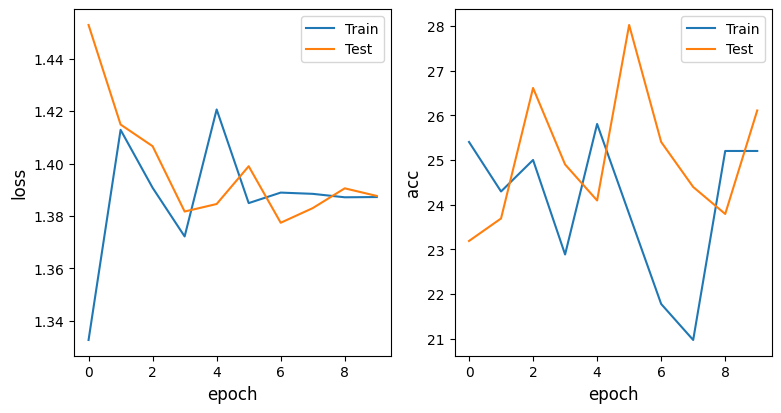

In [13]:
# Setup the training and test data generators
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

# RNN: Increasing Epoch to 100


[Epoch 100/100] loss: 1.3846, acc: 26.11% - test_loss: 1.3934, test_acc: 25.30%


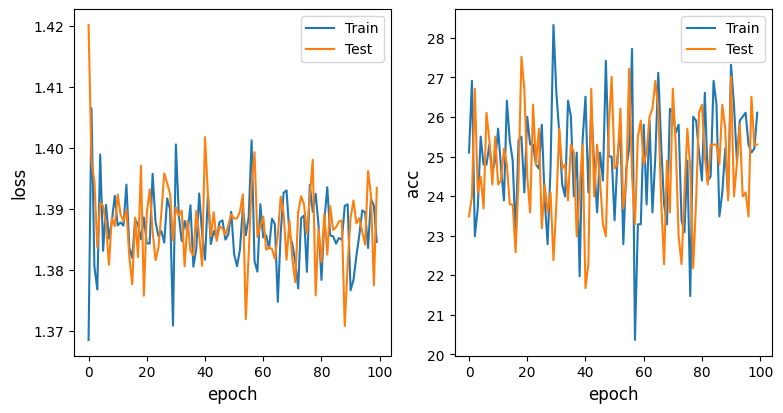

In [14]:
# Setup the training and test data generators
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

# LSTM: Increasing Epoch to 100

[Epoch 100/100] loss: 1.3820, acc: 26.51% - test_loss: 1.3943, test_acc: 26.01%


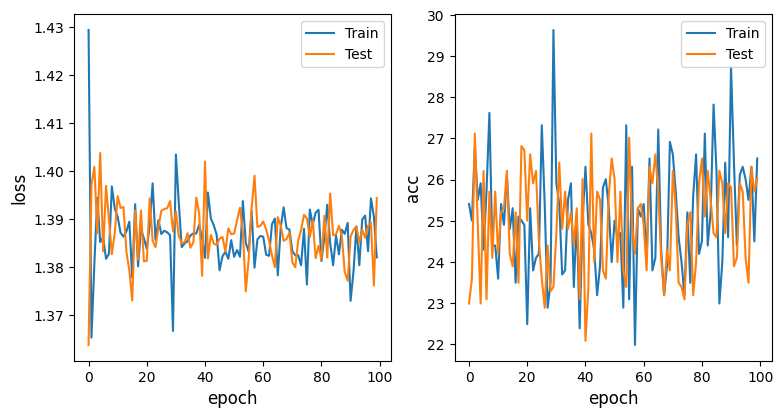

In [15]:
# Setup the training and test data generators
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

# Model Evaluation


In [16]:
import collections
import random

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator
    data_generator = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.cpu().numpy())
            target_decoded = data_generator.decode_y_batch(target.cpu().numpy())

            output = model(data)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))

    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Report some random sequences for examination
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')

In [17]:
evaluate_model(model, difficulty)

The accuracy of the model is measured to be 26.01%.

Q: 258 / 258 correct
R: 0 / 249 correct
S: 0 / 232 correct
U: 0 / 253 correct

Here are some example sequences:
BaXdbXE -> Q was labelled Q
BbXcXbcE -> Q was labelled Q
BbXcXbcE -> Q was labelled Q
BaXdbXE -> Q was labelled Q
BbXcXbcE -> Q was labelled Q
BbXcXbE -> Q was labelled Q
BdXdXcbE -> Q was labelled Q
BcXbdXcE -> Q was labelled Q
BbXbXaE -> Q was labelled Q
BaXdbXE -> Q was labelled Q

There were no misclassified sequences.


#Question:


*   Compare the results(loss and accuracy) for RNN and LSTM on 5 epochs
*   What are the advantages of using an LSTM over a standard RNN?




Sources:

- https://github.com/Atcold/pytorch-Deep-Learning
- Dive into Deep learning [link](https://www.d2l.ai/chapter_multilayer-perceptrons/index.html)
- https://cs231n.github.io/convolutional-networks/
- https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/
- https://github.com/jerofad/pytorch-Deep-Learning-Minicourse